<font size="+4">`Signal and Audio Processing`</font>

<font size="+3">`Seminar 01: Введение в сигналы. Discrete Fourier Transform`</font>

<font size="+2">`Maks Nakhodnov & Dmitry Kropotov`</font>

<font size="+2">`Bremen, 2026`</font>

Что вы узнаете из этого ноутбука:

*   **Природа сигналов:** Чем отличаются аналоговые, дискретные и цифровые сигналы; как работает квантование и как оценивать его качество.
*   **Математический фундамент:** Сигнал как вектор в Гильбертовом пространстве, ортонормированные базисы.
*   **Преобразование Фурье (DFT):** Как разложить сигнал на частоты, Быстрое Преобразование Фурье.
*   **Физический смысл спектра:** Что такое частотные бины, почему разрешение зависит от длительности записи ($T$), а не от частоты дискретизации ($F_s$).
*   **Алиасинг и Теорема Котельникова:** Почему возникают ложные частоты, что такое частота Найквиста и почему спектр вещественного сигнала симметричен.

In [1]:
import os
import sys
import time
from functools import partial

import numpy as np
import scipy as sc
import pandas as pd

import sounddevice as sd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import plotly.graph_objects as go

from ipywidgets import interact
from IPython.display import Audio, HTML

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# `Сигналы и математические основы`

<b style='color:red;'>Что такое сигнал? Зачем он нужен? Как его обрабатывать?</b>

<details><summary>Ответ:</summary>>> Сигнал — формальное описание феномена, развивающегося во времени.</details>

Пример сигнала — зависимость температуры в комнате от времени.

<b style='color:red;'>Что характеризует сигнал?</b>
<details><summary>Ответ:</summary> В простейшем случае — его амплитуда в каждый момент времени. </details>

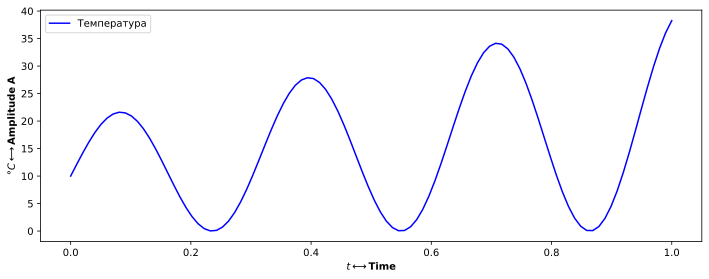

In [2]:
xs = np.linspace(0.0, 1.0, 100)
ys = 10 * (xs + 1.0) * (np.sin(20 * xs) + 1.0)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(xs, ys, color='blue', label='Температура')

ax.set_xlabel(r'$t \longleftrightarrow \bf{Time}$')
ax.set_ylabel(r'$\degree C \longleftrightarrow \bf{Amplitude}\;A$')
ax.legend()
plt.tight_layout()
plt.show()

## `Виды сигналов`

Основные 3 вида сигналов:
1. **Аналоговые** — определены на непрерывном интервале, например, $\mathbb{R}$, и в каждый момент могут принимать произвольные значения, обычно $\mathbb{R}$ или $\mathbb{C}$:
$$
s(t): \mathcal{T} \longrightarrow \mathcal{A}
$$

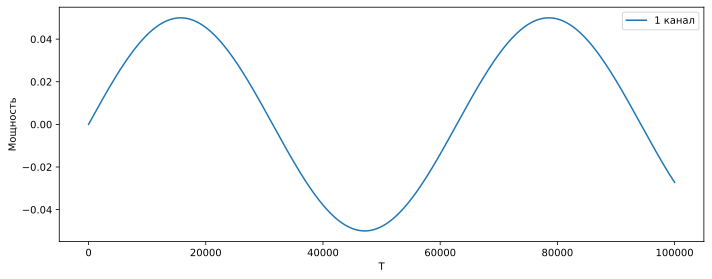

In [3]:
analog_signal = lambda t: np.sin(1 * t) / 20

display(Audio(data=analog_signal(np.linspace(0.0, 10.0, 100000)), rate=44100, normalize=False))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(analog_signal(np.linspace(0.0, 10.0, 100000)), label='1 канал')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Мощность')
fig.tight_layout()
plt.show()

<b style='color:red;'>Почему ничего не слышно? Вроде бы мы какой-то сигнал сделали?</b>
<details><summary>Ответ:</summary> 
В звуке нам важна частота колебаний, а не само абсолютное давление!
</details>

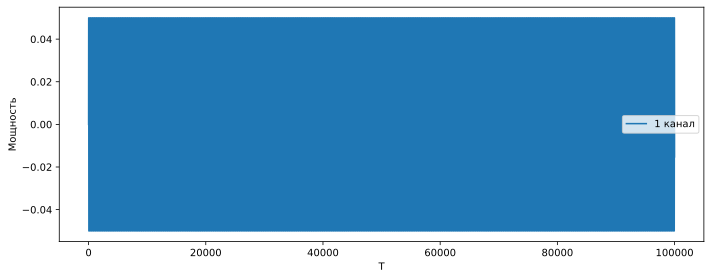

In [4]:
analog_signal = lambda t: np.sin(1000 * t) / 20

display(Audio(data=analog_signal(np.linspace(0.0, 10.0, 100000)), rate=44100, normalize=False))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(analog_signal(np.linspace(0.0, 10.0, 100000)), label='1 канал')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Мощность')
fig.tight_layout()
plt.show()

2. **Дискретные** — определены на дискретном множестве, например, $\mathbb{N}$ или $\mathbb{Z}$, и в каждый момент могут принимать произвольные значения.

Обычно дискретный сигнал задаётся как последовательность, через его отсчёты на некотором сигнале $s(t)$ с непрерывным временем:

$$
s[n] = s(t_{n}),\;\text{где обычно берётся равномерная сетка:}\;s[n] = s(n \Delta t)
$$

Такое представление позволяет расширить дискретные сигналы до аналоговых:
$$
s_{d}(t) = s(t) * ш_{T}(t),\;\text{где}\;ш_{T}(t)\;-\;\text{решётчатая функция, определяющая отсчёты времени}
$$

Для равномерной сетки на $\mathbb{R}$ будет верно следующее представление решётчатой функции, которое нам пригодится в дальнейшем:
$$
ш_{T}(t) = \sum\limits_{n=-\infty}^{\infty} \delta(t - n\Delta t) \Rightarrow s_{d}(t) = \sum\limits_{n=-\infty}^{\infty} s(t)\delta(t - n\Delta t)
$$

*Данное преобразование задаёт **идеальную дискретизацию** сигнала $s(t)$. В реально мире, идеальной дискретизации не бывает, вместо этого используется приближение решётчатой функции, но в данном курсе мы не будем это учитывать*.

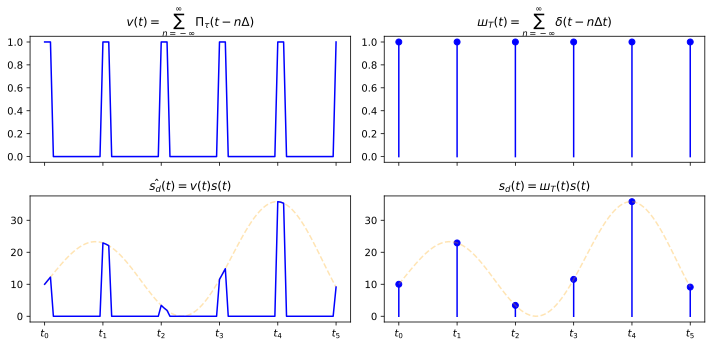

In [5]:
xs = np.linspace(0.0, 1.0, 101)
ys = 10 * (xs + 1.0) * (np.sin(10 * xs) + 1.0)

uus = xs * 100 % 20 < 3

fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=False)

axes[0, 0].plot(xs, uus, color='blue')
for x, y in zip(xs[::20], ys[::20]):
    axes[0, 1].plot([x, x], [0, 1], color='blue')
    axes[0, 1].scatter([x], [1], color='blue')

    axes[1, 1].plot([x, x], [0, y], color='blue')
    axes[1, 1].scatter([x], [y], color='blue')

axes[0, 0].set_xticks(xs[::20])
axes[0, 1].set_xticks(xs[::20])
axes[0, 0].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])
axes[0, 1].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])

axes[1, 0].plot(xs, ys, '--', color='orange', alpha=0.3)
axes[1, 1].plot(xs, ys, '--', color='orange', alpha=0.3)
axes[1, 0].plot(xs, ys * uus, color='blue')

axes[0, 0].set_title(r'$v(t) = \sum_{n=-\infty}^{\infty} \Pi_{\tau}(t - n\Delta)$')
axes[0, 1].set_title(r'$ш_{T}(t) = \sum_{n=-\infty}^{\infty} \delta(t - n\Delta t)$')
axes[1, 0].set_title(r'$\hat{s_{d}}(t) = v(t)s(t)$')
axes[1, 1].set_title(r'$s_{d}(t) = ш_{T}(t)s(t)$')


fig.tight_layout()
plt.show()

<b style='color:red;'>Теряем ли мы информацию переходя от аналогового сигнала к дискретному? Ответ на этот вопрос нам даст Теорема Котельникова!</b>

3. **Цифровые** — определены на дискретном множестве, например, $\mathbb{N}_{+}$, и значения берутся также из дискретного множества.

Процедура перехода от дискретного сигнала к цифровому называется **квантование** — разбиение значений величины на конечное число интервалов.

<b style='color:red;'>Например, $s(t) \in [0, 1]$. Как оптимально представить значения сигнала в компьютере, в виде числа (i.e. 4 бита)?</b>
<details><summary>Ответ:</summary> 
<ul>
<li>Равномерное кодирование, $16$ интервалов: $[\frac{i}{16}, \frac{i+1}{16})$.</li>
<li>Неравномерное кодирование, если значения распределены существенно неоднородно.</li>
</ul>
</details>

Посмотрим на реальный цифоровой сигнал:

In [6]:
 # Частота дискретизации (стандарт — 44100 Гц) и Длительность записи в секундах
sample_rate, seconds = 44100, 2 

digital_signal = sd.rec(int(sample_rate * seconds), samplerate=sample_rate, channels=1)
sd.wait()

Audio(data=digital_signal[:, 0], rate=sample_rate)

float32 True


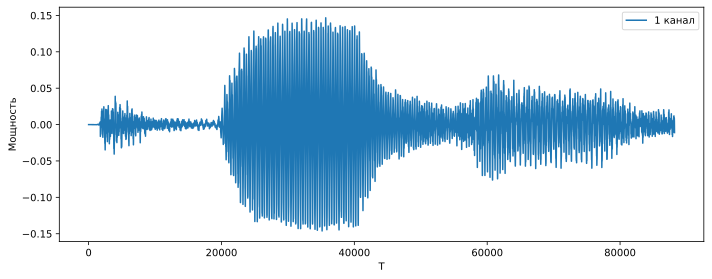

In [7]:
print(digital_signal.dtype, digital_signal.shape[0] == sample_rate * seconds)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(digital_signal[:, 0], label='1 канал')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Мощность')
fig.tight_layout()
plt.show()

В данном случае мы записали значение сигнала в $2 \times 44100 = 88200$ равноотстоящих отсчётах, то есть каждые $1 / 44100$ секунду. При этом значение сигнала может быть любое вещественное число, что по факту даёт нам $\approx 4 \times 10^9$ уникальных значения. 

### `Квантизация`

Попробуем посмотреть как меняется сигнал при более грубой дискретизации:

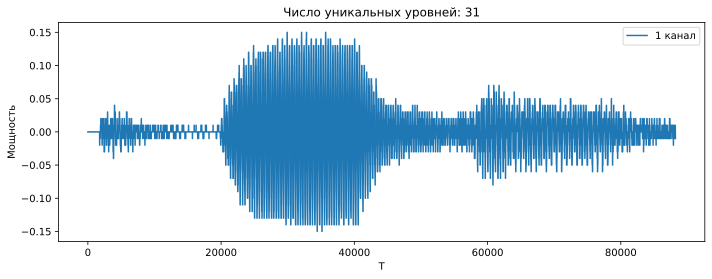

In [8]:
digital_coarse_signal = np.round(digital_signal, 2)

display(Audio(data=digital_coarse_signal[:, 0], rate=sample_rate))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(digital_coarse_signal[:, 0], label='1 канал')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Мощность')

digital_coarse_signal_levels = np.unique(digital_coarse_signal)
ax.set_title('Число уникальных уровней: {0:d}'.format(len(digital_coarse_signal_levels)))
fig.tight_layout()
plt.show()

Мы оставили всего $10$ уникальных значений, то есть заквантовали его в $3.1$ бита.

При этом для конкретного сигнала разные способы дискретизации будут приводить к разному качеству апроксимации. Например, можно итеративно улучшать уровни квантизации (по сути одномерный KMeans):

In [9]:
def lloyd_max(signal, k, iters=10):
    # 1. Инициализация (равномерная по амплитуде)
    levels = np.linspace(signal.min(), signal.max(), k)
    
    for i in range(iters):
        # 2. Находим пороги решения (границы между уровнями)
        thresholds = (levels[:-1] + levels[1:]) / 2
        
        # 3. Привязываем каждое значение сигнала к индексу уровня
        # np.digitize возвращает индексы от 0 до k-1
        indices = np.digitize(signal, thresholds)
        
        # 4. Обновляем уровни (центроиды)
        new_levels = np.zeros(k)
        for j in range(k):
            mask = (indices == j)
            if np.any(mask):
                new_levels[j] = signal[mask].mean()
            else:
                # Если в уровень ничего не попало, оставляем старый
                new_levels[j] = levels[j]
        
        # Гарантируем сортировку для корректной работы np.digitize на след. итерации
        new_levels = np.sort(new_levels)
        
        # Проверка сходимости
        if np.allclose(levels, new_levels, atol=1e-7):
            break
        levels = new_levels
    
    # Финальное квантование
    final_thresholds = (levels[:-1] + levels[1:]) / 2
    final_indices = np.digitize(signal, final_thresholds)
    quantized_signal = levels[final_indices]
    
    return quantized_signal, levels

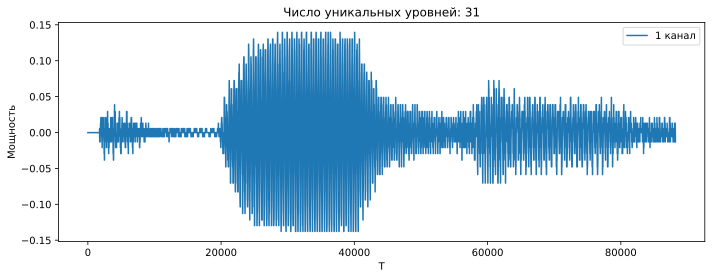

In [10]:
digital_lloyd_signal, levels = lloyd_max(digital_signal[:, 0], len(digital_coarse_signal_levels), iters=50)

display(Audio(data=digital_lloyd_signal, rate=sample_rate))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(digital_lloyd_signal, label='1 канал')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Мощность')
digital_lloyd_signal_levels = np.unique(digital_lloyd_signal)
ax.set_title('Число уникальных уровней: {0:d}'.format(len(digital_lloyd_signal_levels)))
fig.tight_layout()
plt.show()

Новая дискретизация оказывается значительно лучше равномерной, почти в $3$ раза!

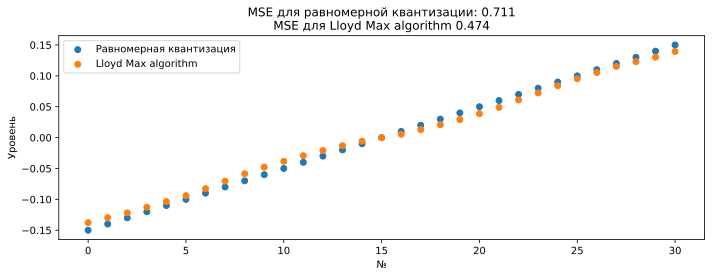

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(np.arange(len(digital_coarse_signal_levels)), digital_coarse_signal_levels, label='Равномерная квантизация')
ax.scatter(np.arange(len(digital_lloyd_signal_levels)), digital_lloyd_signal_levels, label='Lloyd Max algorithm')

ax.legend()
ax.set_xlabel('№')
ax.set_ylabel('Уровень')
ax.set_title(
    'MSE для равномерной квантизации: {0:.3f}\nMSE для Lloyd Max algorithm {1:.3f}'.format(
        np.sum((digital_signal - digital_coarse_signal) ** 2), 
        np.sum((digital_signal[:, 0] - digital_lloyd_signal) ** 2)
    )
)
fig.tight_layout()
plt.show()

### `Метрики качества: SNR и шкала Децибел`

Мы сравнили два метода квантования и увидели, что MSE у Lloyd Max меньше. Однако, само по себе MSE мало о чем говорит, если мы не знаем масштаб самого сигнала.

Чтобы оценка была объективной, нужно сравнивать **силу ошибки** с **силой самого сигнала**. 

Пусть $s[n]$ — дискретный сигнал длины $N$.

*   **Энергия сигнала:**
    $$ E_s = \sum_{n=0}^{N-1} |s[n]|^2 $$

*   **Средняя мощность сигнала:**
    $$ P_s = \frac{1}{N} \sum_{n=0}^{N-1} |s[n]|^2 $$

Чтобы объективно оценить качество, нужно сравнить **мощность полезного сигнала** с **мощностью шума** (в нашем случае шумом является ошибка квантования $e[n] = s[n] - s_q[n]$).

Определим качество как отношение **мощности полезного сигнала** к **мощности шума** (в нашем случае шумом является ошибка квантования $e[n] = s[n] - s_q[n]$).

$$ \text{SNR} = \frac{P_{\text{signal}}}{P_{\text{noise}}} = \frac{\sum |s[n]|^2}{\sum |s[n] - s_q[n]|^2} $$

В обработке сигналов отношения мощностей могут быть гигантскими — линейная шкала неудобна. Кроме того, человеческое восприятие (слух, зрение) работает логарифмически (см. [Закон Вебера — Фехнера](https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law|)). Поэтому используется логарифмическая единица — **Бел** (в честь Александра Белла), а на практике — одна десятая часть, **Децибел**.

**Децибел**  — это безразмерная логарифмическая единица, показывающая отношение физической величины к некоторому эталону.

* **Для энергетических величин (Мощность, Энергия, Интенсивность):**
$$ L_{dB} = 10 \cdot \log_{10}\left( \frac{P}{P_{ref}} \right) $$

* **Для силовых величин (Амплитуда, Напряжение, Ток):**
Так как мощность пропорциональна квадрату амплитуды ($P \sim A^2$), то, множитель удваивается:
$$ L_{dB} = 10 \cdot \log_{10}\left( \frac{A^2}{A_{ref}^2} \right) = 20 \cdot \log_{10}\left( \frac{A}{A_{ref}} \right) $$

Следовательно, для нашего SNR в децибелах:
$$ \text{SNR}_{dB} = 10 \cdot \log_{10}\left( \frac{P_{\text{signal}}}{P_{\text{noise}}} \right) $$

**Правило «6 бит» (SQNR)**

Для оценки квантования можно вывести связь между битностью и его качеством. Предположим, что сигнал был заквантован в $b$ бит. 

Тогда, увеличив битность на $1$ число уровней изменится от $2^b \to 2^{b+1}$. Заметим, что шаг квантования, а как следствие максимальная амплитуда ошибки уменьшится в два раза: $A_{\text{noise}_{\text{new}}}  \approx \frac{1}{2} A_{\text{noise}_{\text{old}}}$.

Подставим в формулу для $\text{SNR}$:
    $$ \Delta \text{SNR}_{dB} = 20 \cdot \log_{10}\left( \frac{A_{\text{noise}_{\text{old}}}}{A_{\text{noise}_{\text{new}}}} \right) \approx 20 \cdot 0.301 = 6.02 \text{dB} $$

Получаем эмпирическое правило: **каждый дополнительный 1 бит при квантовании добавляет $\approx 6$ dB к качеству сигнала.**

**Примеры:**
*   **8 бит** (старая телефония): $8 \times 6 = 48$ dB.
*   **16 бит** (Audio CD): $16 \times 6 = 96$ dB.

In [12]:
snr_db_coarse = 10 * np.log10(
    np.mean(digital_signal[:, 0] ** 2) / np.mean((digital_signal[:, 0] - digital_coarse_signal[:, 0]) ** 2)
)
snr_db_lloyd = 10 * np.log10(
    np.mean(digital_signal[:, 0] ** 2) / np.mean((digital_signal[:, 0] - digital_lloyd_signal) ** 2)
)

snr_db_coarse, snr_db_lloyd

(24.273176193237305, 26.034772254920107)

То есть используя умное квантование мы "выиграли" $1$ бит информации и наше кодирование будет значительно более эффективным по памяти.

### `Категоризация дискретных сигналов`  

*В нашем курсе мы в основном сосредоточимся на дискретных сигналах: дискретное время и непрерывная амплитуда.*

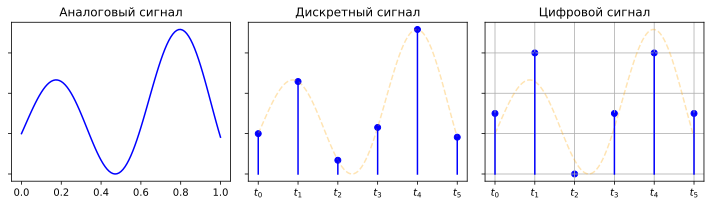

In [13]:
xs = np.linspace(0.0, 1.0, 101)
ys = 10 * (xs + 1.0) * (np.sin(10 * xs) + 1.0)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].plot(xs, ys, color='blue')
axes[1].plot(xs, ys, '--', color='orange', alpha=0.3)
axes[2].plot(xs, ys, '--', color='orange', alpha=0.3)

for x, y in zip(xs[::20], ys[::20]):
    axes[1].plot([x, x], [0, y], color='blue')
    axes[2].plot([x, x], [0, np.round(y / 15) * 15], color='blue')
    axes[1].scatter([x], [y], color='blue')
    axes[2].scatter([x], [np.round(y / 15) * 15], color='blue')
axes[1].set_xticks(xs[::20])
axes[2].set_xticks(xs[::20])
axes[1].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])
axes[2].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])

axes[0].yaxis.set_ticklabels([])
axes[0].yaxis.set_ticklabels([])
axes[1].yaxis.set_ticklabels([])
axes[1].yaxis.set_ticklabels([])
axes[2].yaxis.set_ticklabels([])
axes[2].yaxis.set_ticklabels([])

axes[2].grid(True)

axes[0].set_title('Аналоговый сигнал')
axes[1].set_title('Дискретный сигнал')
axes[2].set_title('Цифровой сигнал')

plt.tight_layout()
plt.show()

Дискретные сигналы обычно разделяют по $3$ классам:

1. **Конечные**: $s[n], n \in \{0, ..., N - 1\}$
2. **Периодические**: $s[n] = s[n + kN],\;\forall\;k\in\mathbb{Z}$
3. **Апериодические**: $s[n], n\in\mathbb{Z}$

Бесконечные сигналы можно получать из конечных естественным образом:

**Апериодические** $\overset{\text{Дополнение нулями}}{\Longleftarrow}$ **Конечные** $\overset{\text{Повторение}}{\Longrightarrow}$ **Периодические**

## `Примеры сигналов`

Разберём несколько примеров дискретных сигналов. В общем виде определим сигнал $s[n] \in \mathbb{C}, n \in \mathbb{Z}$.

1. **Импульс**:
$
\delta[n] = \begin{cases}
    1, &n = 0 \\
    0, &n \ne 0
\end{cases}
$

Будет нужен для анализа систем: будем смотреть как система реагирут на такой сигнал. Например, если система — помещение. Как помещение разносит эхо? 

Импульсная характеристика (RIR) — реакция системы на входной сигнал в виде бесконечно короткого импульса.

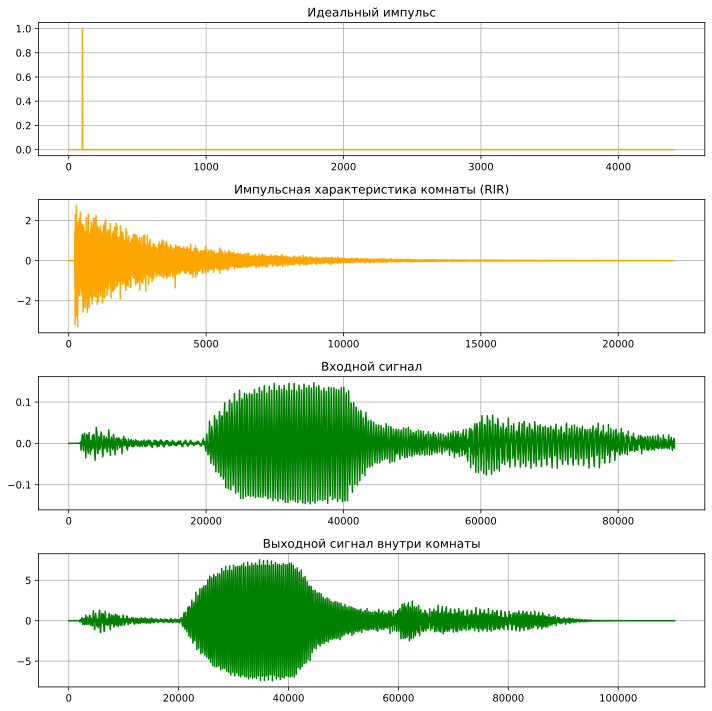

In [14]:
def create_room_impulse_response(duration=1.0, fs=44100, rt60=0.):
    """
    Генерирует упрощенную импульсную характеристику комнаты.
    rt60 - время, за которое звук затухает на 60 дБ (время реверберации).
    """
    t = np.linspace(0, duration, int(fs * duration))
    
    # 1. Генерируем случайный шум (отражения)
    noise = np.random.normal(0, 1, len(t))
    
    # 2. Создаем огибающую экспоненциального затухания
    # Формула для затухания: A = exp(-6.9 * t / RT60)
    envelope = np.exp(-6.91 * t / rt60)
    
    # 3. Моделируем RIR: шум * затухание
    rir = noise * envelope
    
    # 4. Добавляем "прямой звук" (самый сильный первый пик)
    rir[0] = 1.0 
    
    # Убираем шум в самом начале (имитация задержки распространения звука)
    pre_delay = int(0.005 * fs) # 5 мс задержки
    rir = np.concatenate([np.zeros(pre_delay), rir[:-pre_delay]])
    
    return rir

fs, duration = 44100, 1.5

# 1. Создаем импульс
impulse_input = np.zeros(int(fs * 0.1)) 
impulse_input[100] = 1.0

# 2. Моделируем "Комнату"
room_ir = create_room_impulse_response(duration=0.5, fs=fs, rt60=0.5)

# 3. Пропускаем сигнал через систему
output_signal = sc.signal.convolve(impulse_input, room_ir, mode='full')
output_digital_signal = sc.signal.convolve(digital_signal[:, 0], room_ir, mode='full')

fig, axes = plt.subplots(4, 1, figsize=(10, 10))

axes[0].plot(impulse_input, color='orange')
axes[1].plot(room_ir, color='orange')
axes[2].plot(digital_signal, color='green')
axes[3].plot(output_digital_signal, color='green')

axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[3].grid()

axes[0].set_title("Идеальный импульс")
axes[1].set_title("Импульсная характеристика комнаты (RIR)")
axes[2].set_title("Входной сигнал")
axes[3].set_title("Выходной сигнал внутри комнаты")

fig.tight_layout()
plt.show()

display(Audio(data=impulse_input, rate=fs))
display(Audio(data=room_ir, rate=fs))
display(Audio(data=digital_signal[:, 0], rate=sample_rate))
display(Audio(data=output_digital_signal, rate=fs))

2. **Ступенька**:
$
u[n] = \begin{cases}
    1, &n \ge 0 \\
    0, &n < 0
\end{cases}
$

Пример: резко включили ток в системе. Изменение тока $\Leftarrow$ переменное магнитное поле $\Leftarrow$ переменное электрическое поле $\Leftarrow$ Как себя будет вести система?

![](https://electroandi.ru/images/posledovatelnaya-rl-tsep/posledovatelnaya-rl-tsep-1.jpg)

Рассмотрим простейшую RL-цепь. Её можно описать следующим дифференциальным уравнением:

$$L\frac{dI(t)}{dt} + RI(t) = U(t)$$

Положим, что мы моделируем включение напряжения в такой цепи фиксированного напряжения $V$.

В начальный момент ток через систему не идёт: $U(0) = 0 \Rightarrow I(0) = 0$

Затем, $L\frac{dI(t)}{dt} + RI(t) = V$ можно решить рассмотрев решение как сумму однородного:
$$
L\frac{dI(t)}{dt} + RI(t) = 0 \Longrightarrow I_{h}(t) = A \times e^{-\frac{R}{L}t}
$$

и неоднородного уравнения можно найти частное решение:
$$
L\frac{dI(t)}{dt} + RI(t) = V \Longrightarrow \{\frac{dI(t)}{dt} = 0\} \Longrightarrow I_{p}(t) = \frac{V}{R}
$$

Итого, учитывая начальное решение:
$$
I(t) = \frac{V}{R}(1 - e^{-\frac{R}{L}t}) \mathbb{1}[t >= 0]
$$

Таким образом сигнал-ступенька воздействуя на систему из RL-цепь пораждает сигнал-силу тока с эскпоненциальным поведением.

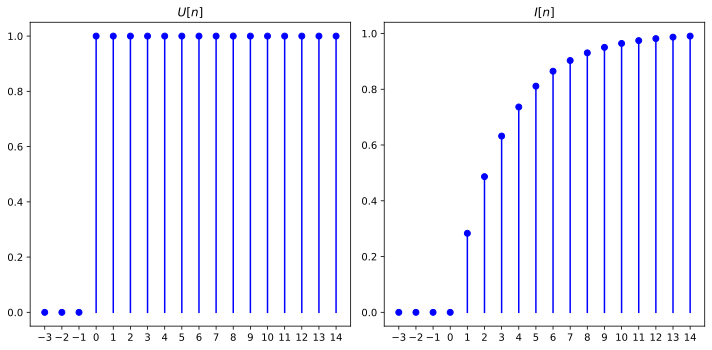

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

V, R, L = 1.0, 1.0, 3.0
for n in range(-3, 15):
    axes[0].plot([n, n], [0.0, 1.0 * (n >= 0)], color='blue')
    axes[0].scatter([n], [1.0 * (n >= 0)], color='blue')
    
    axes[1].plot([n, n], [0.0, V / R * (1 - np.exp(-R / L * n)) * (n >= 0)], color='blue')
    axes[1].scatter([n], [V / R * (1.0 - np.exp(-R / L * n)) * (n >= 0)], color='blue')

axes[0].set_xticks(range(-3, 15))
axes[1].set_xticks(range(-3, 15))
axes[0].set_title('$U[n]$')
axes[1].set_title('$I[n]$')
    
fig.tight_layout()
plt.show()

3. **Экспоненциальное затухание**: $s[n] = a^n u[n], a\in\mathbb{C}, |a|<1$

Пример: закон радиоактивного распада: cкорость распада пропорциональна количеству вещества. $\frac{dN}{dt} = -\lambda N \Rightarrow N(t) = N_{0}e^{-\lambda t}$. 

4. **Комплексная экспонента**: $s[n] = e^{j (w_{0}n + \phi)} = cos(w_{0}n + \phi) + j sin(w_{0}n + \phi)$, где $j$ — мнимая единица.

Пример: ток, напряжение, сопративление в системах с переменным током.

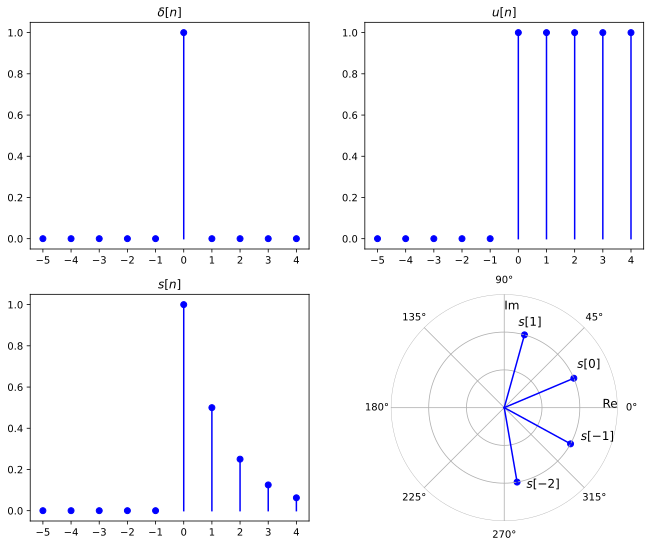

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))
ax4_polar = fig.add_axes(axes[1, 1].get_position(), projection='polar', frameon=False)
axes[1, 1].set_axis_off()

for n in range(-5, 5):
    axes[0, 0].plot([n, n], [0.0, 1.0 * (n == 0)], color='blue')
    axes[0, 0].scatter([n], [1.0 * (n == 0)], color='blue')
    
    axes[0, 1].plot([n, n], [0.0, 1.0 * (n >= 0)], color='blue')
    axes[0, 1].scatter([n], [1.0 * (n >= 0)], color='blue')
    
    axes[1, 0].plot([n, n], [0.0, (0.5 ** n) * (n >= 0)], color='blue')
    axes[1, 0].scatter([n], [(0.5 ** n) * (n >= 0)], color='blue')

w_0, phi = 0.9, 0.4
for n in range(-2, 2):
    ax4_polar.plot([0, w_0 * n + phi], [0.0, 1.0], color='blue')
    ax4_polar.scatter([w_0 * n + phi], [1.0], color='blue')
    ax4_polar.annotate(f'$s[{n}]$', (w_0 * n + phi + 0.1, 1.1), fontsize=12)
    
axes[0, 0].set_xticks(range(-5, 5))
axes[0, 1].set_xticks(range(-5, 5))
axes[1, 0].set_xticks(range(-5, 5))
ax4_polar.set_yticks([0.0, 0.5, 1.0, 1.5])
ax4_polar.set_yticklabels(['', '', '', ''])

ax4_polar.annotate('Im', (np.pi / 2, 1.3), fontsize=12)
ax4_polar.annotate('Re', (0.0, 1.3), fontsize=12)

axes[0, 0].set_title(r'$\delta[n]$')
axes[0, 1].set_title(r'$u[n]$')
axes[1, 0].set_title(r'$s[n]$')

plt.show()

## `Сигналы как элементы векторного пространства`

Представление сигнала во временном домене является естественным для человеческого восприятия, однако, с технической точки зрения физические сигналы плохо поддаются к анализу в таком представлении:

1. **Преобразование в LTI-системах (Linear Time-Invariant).**
Большая часть преобразований которые происходят с сигналами в реальном мире может быть описано через взаимодействие сигнала с LTI системами. Например, распространение звука в окружении (комната, усилитель, среда распространения звука). Такие системы меняют значительно меняют вид сигнала в его временном представлении. Оказывается, что представление сигнала как функции **в другом базисе** существенно упрощает анализ.

2. **Сложность операций над сигналами.**
Преобразования из прошлого пункта можно представить в виде операций свёртки:

$$
s[n] \overset{\text{Воздействие системы H}}{\longrightarrow} y[n] = (s * h)[n] = \sum\limits_{k=0}^{N-1} s[k]h[n - k]
$$

Вычисление напрямую данного воздействия имеет сложность $\mathcal{O}(n^{2})$. Однако, переход к **частотному базису** (при определённых условиях!) позволяет снизить сложность до $\mathcal{O}(n\log n)$.

3. **Сжатие сигналов.**
Так как временной базис для реальных сигналов не является естественным, то хранение таких сигналов, как и их эффективная дискретизация без потерь не возможна в исходном базисе. Однако переход в частотное пространство позволяет использовать более компактное предстваление.

Для того, чтобы перейти к другому базису в представлении сигналов, нам нужно определить некоторые векторные свойства сигналов.


**Гильбертово пространство** — линейное, векторное пространство со скалярным произведением $\langle ., .\rangle$, полное относительно его метрики.

Скалярное произведение задаёт естественное расстояние на том же пространстве: $||x||^{2} = \langle x, x \rangle,\;\rho(x, y) = ||x - y||$


**Ортонормированный базис** — $\{b_{k}\}_{k=1}^{\infty} \subset V$:

$$
\forall\;g \in V\;\exists\{\alpha_k\}_{k=1}^{\infty}: g = \sum\limits_{k=1}^{\infty} \alpha_k b_k
$$
$$
\langle b_i, b_j\rangle = \delta_{ij} = \begin{cases}0, i\ne j \\ 1, i = j\end{cases}
$$

# `Ряды Фурье`

**Ряд Фурье [элемента $g$ по системе $\{b_{k}\}$]** — формальное выражение вида $\sum\limits_{k=1}^{\infty} \langle g, b_{k}\rangle b_{k} = \sum\limits_{k=1}^{\infty} g_{k} b_{k}$

Чтобы проверить, что данная система является базисом необходимо и достаточно показать, что для любого элемента $g \in V$ ряд Фурье сходится к $g$.

**Лемма 1.** Коэффициенты частичных сумм Ряда Фурье обеспечивают наилучшее приближение элемента $g$:
$$
||g - \sum\limits_{k=1}^{n} c_{k} b_{k}||^{2} = \sum\limits_{k=1}^{n} (c_{k} - g_{k})^{2} - \sum\limits_{k=1}^{n} g_{k} + ||g||^{2} \Rightarrow argmin_{\{c_{k}\}_{1}^{n}} ||g - \sum\limits_{k=1}^{n} c_{k} b_{k}||^{2} = \{g_{k}\}_{1}^{n}
$$

**Следствие 1. Неравенство Бесселя и Тождество Парсеваля.**
$$
||g - \sum\limits_{k=1}^{n} g_{k} b_{k}||^{2} = ||g||^{2} - \sum\limits_{k=1}^{n} g_{k} \Rightarrow ||g||^{2} \ge \sum\limits_{k=1}^{n} g_{k} \Rightarrow ||g||^{2} \ge \sum\limits_{k=1}^{\infty} g_{k} \Rightarrow\text{Ряд Фурье сходится [не обязательно к $g$]}
$$

Чтобы показать сходимость именно к $g$ нужно наложить дополнительные ограничения на систему векторов.

**Ортонормированная система называется замкнутой**, если для любого элемента $g \in V$, $\forall\;\epsilon > 0$ $\exists \{c_{k}\}_{1}^{N}: ||g - \sum\limits_{k=1}^{n} c_{k} b_{k}||^{2} < \epsilon$.

Очевидно из Леммы 1 и следствия 1, что для замкнутой системы Ряд Фурье сходится к самому элементу. Однако, проверка замкнутости системы затруднительно на практике. Вместо этого можно рассмотреть следующее определение:

**Ортонормированная система называется полной**, если, кроме нулевого элемента, не существует никакого другого элемента $g$ данного евклидова пространства, который был бы ортогонален ко всем элементам $\{b_{k}\}_{1}^{\infty}$ системы.

В гильбертовых пространствах (и даже в предгильбертовых) из замкнутости системы следует её полнота. (Достаточно применить равенство Парсеваля в доказательстве от противного). Обратное доказывается тривиально, однако полнота (то есть гильбертовость пространства) является критичным требованием.

**Важно отметить, что сходимость рядов рассматривается только по норме, что вообще говоря не приводит к поточечной сходимости. Для поточечной и тем более равномерной сходимости нужно накладывать ограничения на сами элементы пространства.**

Теперь, введя необходимый математический аппарат, можно рассмотреть конкретные варианты выбора пространства и системы векторов.

Нужно отметить, что некоторые привычные пространства не являются гильбертовыми и работа с рядами Фурье в них не имеет смысла. Например, в $C[a, b]$ ряд Фурье может сходится к разрывной функции (приведите пример!), которая не лежит в самом пространстве.

1. **Конечные сигналы** можно рассматривать с пространстве $\mathbb{C}^{N}$ со скалярным произведением $\langle s, u \rangle = \sum\limits_{n=0}^{N-1} s[n]\overline{u[n]}$.

2. Классическим выбором гильбертова пространства для **функций от непрерывного аргумента** является пространство квардратично интегрируемых ($\int\limits_{a}^{b} |f(x)|^{2} dx < \infty$) измеримых функций $L^{2}[a, b]$ со скалярным произведением $\langle f, g \rangle = \int\limits_{a}^{b} f(x) g^{\star}(x) dx$. 

3. **Для дискретных функций** можно рассмотреть гильбертово пространство квадратично-суммируемых последовательностей ($\sum |s[n]|^{2} < \infty$) $l^{2}$ со скалярным произведением $\langle s, u \rangle = \sum s[n]\overline{u[n]}$.

4. И наконец, для **функций от непрерывного аргумента**, на неограниченном носителе можно рассмотреть пространство квардратично интегрируемых ($\int\limits_{-\infty}^{\infty} f(x)^{2} dx < \infty$) измеримых функций $L^{2}$ со скалярным произведением $\langle f, g \rangle = \int\limits_{-\infty}^{\infty} f(x) g^{\star}(x) dx$. В этом случае базис такого пространства уже будет несчётным, что, в прочем нас не пугает, мы просто перейдём от суммирования по счётному числу базисных функций к интегрированию. В этом случае вместо Ряда Фурье мы будем изучать **Интеграл Фурье**.

Укажем некоторые полезные достаточные условия поточечной сходимости:

1. В случае конечных сигналов ряды Фурье вырождаются в конечные суммы, а значит вопроса о сходимости не будет! Здесь базис Фурье — это просто ортогональный базис в конечномерном пространстве.
2. Для $L^{2}[a, b]$ есть условия Дирихле:
    * Функция имеет конечное число экстремумов и конечное число разрывов первого рода $\Rightarrow$ ряд Фурье сходится поточечно.
    * Функция непрерывна на всём периоде и имеет кусочно-непрерывную производную $\Rightarrow$ ряд Фурье сходится равномерно.
    * Последовательность коэффициентов Ряда Фурье суммируема по модулю $\Rightarrow$ ряд Фурье сходится равномерно.
3. Конечная сумма модулей $\sum |s[n]| < \infty \Rightarrow$ Ряд Фурье сходится абсолютно и равномерно.
4. Для последнего случая ситуация со сходимостью крайне нетривиальна. Более подробно в каких случаях представление в частотной форме имеет смысл мы обсудим в дальшейшем.
    * Если функция абсолютно интегрируема ($\int\limits_{-\infty}^{\infty} |f(x)| dx < \infty$) $\Rightarrow$ Интеграл Фурье сходится абсолютно и равномерно.

Теперь рассмотрим возможные базисы, образованные полной/замкнутой системой функций.

## $\mathbb{C}^{N}$ `(конечные/периодические дискретные сигналы)`

1. **Канонический базис**
$$ 
\delta_{n}^{(k)} = \delta[n - k] = \begin{cases} 1,& n=k\\0,& \text{иначе} \end{cases},\;\;\;\; n, k \in [0, ..., N-1]
$$

2. **Базис Фурье**
$$w_{n}^{(k)} = \frac{1}{\sqrt{N}}e^{-j\frac{2\pi}{N}nk},\;\;\;\; n, k \in [0, ..., N-1]$$

Несложно проверить что оба этих базиса являются ортонормированными.

In [17]:
N = 4
M = 1 / np.sqrt(N) * np.exp(-1j * 2 * np.pi / N * np.arange(N)[:, None] * np.arange(N)[None, :])

np.linalg.norm(
    (M @ M.conjugate() - np.eye(N))
)

np.round(M, decimals=1)

array([[ 0.5+0.j ,  0.5+0.j ,  0.5+0.j ,  0.5+0.j ],
       [ 0.5+0.j ,  0. -0.5j, -0.5-0.j , -0. +0.5j],
       [ 0.5+0.j , -0.5-0.j ,  0.5+0.j , -0.5-0.j ],
       [ 0.5+0.j , -0. +0.5j, -0.5-0.j ,  0. -0.5j]])

<b style='color:red;'>Так как такой базис периодичен с периодом $N$, то Ряд Фурье будет сходиться не только на $[0, ..., N - 1]$, но и на всём $\mathbb{Z}$ к периодическому продолжению данного дискретного, конечного сигнала.</b>

Запишем переход от одного базиса к другому:

$$
s = \sum s^{\delta}_{n}\delta_{n} = \sum s^{w}_{n} w_{n} \Rightarrow \sum s^{\delta}_{n}\langle \delta_{n}, w_{m} \rangle = s^{w}_{m} \Rightarrow \sum s^{\delta}_{n}w^{(n)}_{m} = s^{w}_{m} = \sum s^{\delta}_{n}M_{nm} \Rightarrow  s^{w} = s^{\delta}M
$$

Обратное преобразование задаётся сопряжённой матрицей $M^{\star}$: $s^{\delta} = s^{w}M^{\star}$.

In [18]:
def plot_011(w=1.6, N=6):
    M = 1 / np.sqrt(N) * np.exp(-1j * 2 * np.pi / N * np.arange(N)[:, None] * np.arange(N)[None, :])
    
    signal = lambda t: np.sin(w * t)
    sn = signal(np.linspace(0.0, np.pi, N))
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].plot(sn, '--', color='orange', alpha=0.3)
    axes[0].plot(sn, 'o', color='blue')
    
    phase, magnitude = np.angle(sn @ M), np.absolute(sn @ M)
    phase[magnitude < 1e-10] = 0
    magnitude[magnitude < 1e-10] = 0
    
    axes[1].plot(phase, 'o', color='blue')
    axes[2].plot(magnitude, 'o', color='blue')
    
    axes[0].set_title(r'$s[n]$')
    axes[1].set_title(r'$Arg(s[w])$')
    axes[2].set_title(r'$Abs(s[w])$')
    
    fig.tight_layout()
    plt.show()

interact(plot_011);

interactive(children=(FloatSlider(value=1.6, description='w', max=4.800000000000001, min=-1.6), IntSlider(valu…

Переход от сигнала к его разложению называют **анализом**, а обратное преобразование — **синтез**:
<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Сигнал</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Преобразование</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Анализ</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Синтез</th></tr></thead>
<tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Конечный<br>Периодический</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">DFT (Discrete Fourier
Transform)<br>DFS (Discrete Fourier
Series)</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">$$S[k] = \frac{1}{\sqrt{N}}\sum\limits_{n=0}^{N-1} s[n] e^{-j\frac{2\pi}{N}kn}$$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">$$s[k] = \frac{1}{\sqrt{N}}\sum\limits_{k=0}^{N-1} S[k] e^{j\frac{2\pi}{N}nk}$$</td></tr></tbody></table>

В данной нотации мы перешли от разложение по базису к стандартной индексации сигналов $s[n]$ и их спектров $S[k]$. Очевидно, что формулы анализа/синтеза симметричны вплоть до комплексного сопряжения.